## Functions and libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from gplearn.genetic import SymbolicTransformer
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from mlens.ensemble import SuperLearner


[MLENS] backend: threading


## Functions for classifier in cross validation

In [2]:
classifiers = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter = 500, C=1, penalty='l2'), 
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000),
    "XGBoost": xgb.XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=3,
                                 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.8, seed=27,
                                 reg_alpha=0.05, reg_lambda=1)
}
def profit_scorer(y, y_pred):
#     print(confusion_matrix(y, y_pred))
    profit_matrix = {(0,0): 0, (0,1): -5, (1,0): -25, (1,1): 5}
    return sum(profit_matrix[(pred, actual)] for pred, actual in zip(y_pred, y))

def evaluate_classification(X, y):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    profit_scoring = make_scorer(profit_scorer, greater_is_better=True)
    for name, clf in classifiers.items():
        result = sum(cross_validate(clf, X, y=y, cv=cv, scoring=profit_scoring)['test_score'])
        print(f"{name}: test core = {result} ")

def code_for_test(X,y):
    """
    test code with 10-fold stratified cross validation
    parameters
    X: trainset features after generation
    y: trainset y label
    """
    evaluate_classification(X, y)

## Functions for automatic feature generation

In [3]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']  # 
def gp(X, y, gen, n_com):
    gp1 = SymbolicTransformer(generations=gen, population_size=1000,
                             hall_of_fame=1000, n_components=n_com,
                             function_set=function_set,
                             parsimony_coefficient=0.0005,
                             max_samples=0.9, verbose=1,
                             random_state=42, n_jobs=3,
                             feature_names=X.columns)
    x_gp = gp1.fit_transform(X, y)
    code_for_test(x_gp, y)
    return gp1, x_gp

## functions for semi-supervised learning

In [4]:
def classify(X_train, X_test, y_train, clf):
    pred = clf.fit(X_train, y_train).predict(X_test)
    return pred

def cv_cost_semi(X, X_test_other, y):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost = {
    "Logistic Regression": 0, 
    "Neural Net": 0,
    "XGBoost": 0,
    "ensemble": 0}
    for train_index, test_index in cv.split(X, y):
        # get the split
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        # generate coresponding test label
        # model = LabelSpreading(gamma=10)
        model = LabelPropagation(alpha=None, gamma=10, kernel='rbf', max_iter=1000,n_jobs=None, n_neighbors=7, tol=0.001)
#         model = LabelSpreading(alpha=0.2, gamma=10, kernel='rbf', max_iter=30, n_jobs=None,n_neighbors=7, tol=0.001)
        y_new_label = model.fit(X_train, y_train).predict(X_test_other)
        X_all = np.vstack((X_train,X_test_other))
        
        y_all = y_train.append(pd.DataFrame(y_new_label))
        # evaluation 
        for name, clf in classifiers.items():
            pred = classify(X_all, X_test, y_all, clf)
            cost[name] += profit_scorer(y_test, pred>0.5)
    print(f'cost = {cost}')

## functions for cost-sensitive xgboost

In [5]:
# cost sensitive objective function and derivative
def logistic_obj(y_hat, dtrain, alpha=5, beta=25): # alpha for FN beta for FP
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-y_hat))
    grad = pred * (beta + alpha*y - beta*y) - alpha*y  # alpha*(p-1)*y + beta*p*(1-y)
    hess = pred * (1 - pred) * (beta + alpha*y - beta*y)
    return grad, hess

# calculate the error
def err_rate(pred, dtrain):
    y = dtrain.get_label()
    pred = 1. / (1. + np.exp(-pred))
    loss_fn = y*np.log(pred)
    loss_fp = (1.0 - y)*np.log(1.0 - pred)
    return 'error', np.sum(-(5*loss_fn+25*loss_fp))/len(y)

# train on one cross_validation split
def cross_validation(X_train, X_test, y_train, y_test, depth, num_round):
    # load data
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_val = xgb.DMatrix(X_test, label=y_test)
    # build model
    param = {'max_depth': depth, 'eta': 0.2, 'silent': 1, 'seed': 42, 'scale_pos_weight':1}
#     watchlist = [(d_val, 'eval'), (d_train, 'train')]
#     model_trn = xgb.train(param, d_train, num_round, watchlist, obj=logistic_obj, feval=err_rate)
    model_trn = xgb.train(param, d_train, num_round, obj=logistic_obj, feval=err_rate)
    # prediction
    pred = model_trn.predict(d_val) 
    pred = 1. / (1. + np.exp(-pred))
    return pred

# train on all cross-validation set
def cv_cost_xg(X,y, depth, rounds):
    cv = StratifiedKFold(n_splits=10, random_state=42)
    cost=0
    if type(X) == pd.DataFrame:
        X=X.values
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pred = cross_validation(X_train, X_test, y_train, y_test, depth, rounds)
        cost += profit_scorer(y_test, pred>0.5)
    print(f'cost = {cost}')

#train on all train set   
def train_xgb(X_train, y_train, X_test):
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test)
    param = {'max_depth': 3, 'eta': 0.2, 'silent': 1, 'seed': 42, 'scale_pos_weight':1}
    model_trn = xgb.train(param, d_train, 100, obj=logistic_obj, feval=err_rate)
    pred = model_trn.predict(d_train)
    pred = 1. / (1. + np.exp(-pred))
    print(f'cost on train = {profit_scorer(y, pred>0.5)}')
    print(confusion_matrix(y, pred>0.5))
    pred_test = model_trn.predict(d_test)
    pred_test = 1. / (1. + np.exp(-pred_test))
    return model_trn, pred_test

## Dataset for test
prepare different input dataset and test at 10-fold stratified cross validation set


## Raw data

In [6]:
#raw data
train_data = pd.read_csv('data/train.csv', sep = '|')
test_data = pd.read_csv('data/test.csv', sep = '|')
print(f'Train set has {train_data.shape[0]} entries and {train_data.shape[1]} features')
print(f'Test set has {test_data.shape[0]} entries and {test_data.shape[1]} features')
y = train_data['fraud']
X = train_data.drop(columns=['fraud']).astype(float)

Train set has 1879 entries and 10 features
Test set has 498121 entries and 9 features


## Manual feature

In [7]:
# delete correlate features
X_manual = X.assign(no_item = X.totalScanTimeInSeconds* X.scannedLineItemsPerSecond)\
                     .drop(columns=['valuePerSecond', 'lineItemVoidsPerPosition','scannedLineItemsPerSecond'])
X_test = test_data.assign(no_item = test_data.totalScanTimeInSeconds* test_data.scannedLineItemsPerSecond)\
                    .drop(columns=['valuePerSecond', 'lineItemVoidsPerPosition','scannedLineItemsPerSecond'])

fit_minmax = MinMaxScaler()
# normalize with encode
X_manual_encode = pd.get_dummies(X_manual, columns=['trustLevel'], prefix='trustLevel')
X_test_encode = pd.get_dummies(X_test, columns=['trustLevel'], prefix='trustLevel')
X_train_manual_enc = pd.DataFrame(fit_minmax.fit_transform(X_manual_encode), columns=X_manual_encode.columns, index=X_manual_encode.index)
X_test_manual_enc = pd.DataFrame(fit_minmax.transform(X_test_encode), columns=X_manual_encode.columns, index=X_test_encode.index)


In [8]:
code_for_test(X_train_manual_enc,y)

Logistic Regression: test core = 205 
Neural Net: test core = 200 
XGBoost: test core = 215 


## Auto generate feature

In [9]:
gpresult, xgp = gp(X_train_manual_enc, y, 100, 40)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.86         0.094761        9         0.707305         0.651601      4.79m
   1     9.58         0.276511       14         0.722464         0.744651      2.58m
   2     8.42         0.469678       14         0.783092         0.807669      2.73m
   3    11.46          0.63334       17         0.808567         0.733662      2.75m
   4    15.33          0.69389       31         0.813072         0.626655      2.98m
   5    17.37         0.712183       17         0.818479         0.644542      3.30m
   6    18.83         0.732394       21         0.823698         0.546554      3.27m
   7    19.90         0.747221       34         0.823915         0.659249      3.07m
   8    19.84         0.742844       30         0.827044          0.59718  

  94    50.18         0.770984      106          0.92963          0.95864     17.65s
  95    49.72         0.759817       70          0.93057          0.86936     12.87s
  96    50.59         0.769957       50         0.933293         0.795149      9.78s
  97    49.91          0.76969       70         0.934764         0.753906      6.77s
  98    50.27          0.76229       74         0.937564         0.865825      3.66s
  99    49.87         0.767216       70         0.938455         0.707139      0.00s
Logistic Regression: test core = 310 
Neural Net: test core = 340 
XGBoost: test core = 300 


## Ensemble (stacking)

In [10]:
ensemble = SuperLearner()
ensemble.add(list(classifiers.values()))
ensemble.add_meta(LogisticRegression())
classifiers['ensemble'] = ensemble

In [11]:
code_for_test(xgp, y)

Logistic Regression: test core = 310 
Neural Net: test core = 330 
XGBoost: test core = 300 
ensemble: test core = 325 


## Define xgboost with cost sensitive

In [12]:
cv_cost_xg(xgp, y, 3 ,100)

cost = 325


## semi-supervised


In [13]:
x_test12 = X_test_manual_enc[X_test_manual_enc['trustLevel_1.0']==1].append(X_test_manual_enc[X_test_manual_enc['trustLevel_2.0']==1])
xgp_test12 = gpresult.transform(x_test12)

In [14]:
cv_cost_semi(xgp, xgp_test12, y)

cost = {'Logistic Regression': 275, 'Neural Net': 280, 'XGBoost': 230, 'ensemble': 240}


## final prediction

In [15]:
def final_model(x,y,x_test, clf):
    clf.fit(x,y)
    y_pred = clf.predict(x)
    print(f'cost on train = {profit_scorer(y, y_pred>0.5)}')
    print(confusion_matrix(y, y_pred>0.5))
    prediction = clf.predict(x_test)
    return prediction

In [17]:
xgp_test = gpresult.transform(X_test_manual_enc)

Logistic Regression
cost on train = 375
[[1772    3]
 [   7   97]]
result on test: Counter({0: 475423, 1: 22698})
Neural Net
cost on train = 350
[[1773    2]
 [  12   92]]
result on test: Counter({0: 476562, 1: 21559})
XGBoost
cost on train = 485
[[1774    1]
 [   1  103]]
result on test: Counter({0: 473756, 1: 24365})
ensemble
cost on train = 425
[[1774    1]
 [   7   97]]
result on test: Counter({0.0: 475905, 1.0: 22216})
XGBoost cost sensitive
cost on train = 520
[[1775    0]
 [   0  104]]
result on test: Counter({False: 474345, True: 23776})


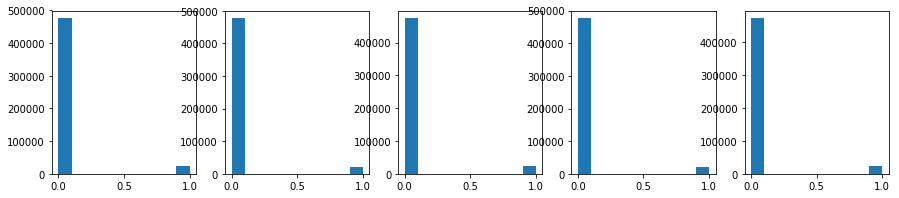

In [24]:
fig, ax = plt.subplots(1,5)
fig.set_figheight(3)
fig.set_figwidth(15)
i = 0

for name, clf in classifiers.items():
    print(name)
    prediction = final_model(xgp, y, xgp_test, clf)
    np.savetxt(f"Result/fraud_{name}.csv", (prediction>0.5), delimiter=",", fmt='%d')
    ax[i].hist(prediction)
    i+=1
    print(f'result on test: {collections.Counter(prediction)}')

print('XGBoost cost sensitive')
model, cost_xgb_pred = train_xgb(xgp, y, xgp_test)
np.savetxt(f"Result/fraud_XGBoost cost sensitive.csv", (cost_xgb_pred>0.5), delimiter=",", fmt='%d')
ax[4].hist(cost_xgb_pred)
print(f'result on test: {collections.Counter(cost_xgb_pred>0.5)}')